In [31]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
manualSeed = 999
print("Random Seed: ", manualSeed)
result = random.seed(manualSeed)
print("random.seed(manualSeed): ", result)
result = torch.manual_seed(manualSeed)
print("torch.manual_seed(manualSeed): ", result)

Random Seed:  999
random.seed(manualSeed):  None
torch.manual_seed(manualSeed):  <torch._C.Generator object at 0x7fd0e7d42e90>


**Hyperparameter**

In [34]:
# Hyperparameter

# Root directory for dataset
dataroot = "/content/drive/MyDrive/celeba"
 
# Number of workers for dataloader
workers = 2
 
# Batch size during training
batch_size = 128  # this is the number used in the paper
 
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
 
# Number of channels in the training images. For color images this is 3 (RGB)
nc = 3
 
# Size of z latent vector (i.e. size of generator input)
nz = 100
 
# Size of feature maps in generator
ngf = 64
 
# Size of feature maps in discriminator
ndf = 64
 
# Number of training epochs
num_epochs = 5
 
# Learning rate for optimizers
lr = 0.0002
 
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5 # same as the paper
 
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

**Load Data**

In [35]:
# print(dataroot)
dataset = dset.ImageFolder(root=dataroot,
              transform=transforms.Compose([
                  transforms.Resize(image_size),
                  transforms.CenterCrop(image_size),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
              ]))


In [36]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=True, num_workers=2)

In [37]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and gpu>0) else "cpu")
print(device)

cpu


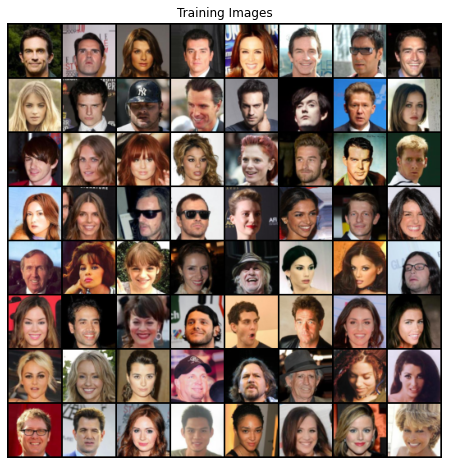

In [38]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**Weight Initialization**

In [39]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Generator**

In [44]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator,self).__init__()
    self.ngpu = ngpu
    self.conv1 = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d(in_channels=nz, out_channels=ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True)
    )

    self.conv2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=ngf*8, out_channels=ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
    )

    self.conv3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True)
    )


    self.conv4 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
    )

    self.out = nn.Sequential(
        nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )


    def forward(self, input):
      input = self.conv1(input)
      input = self.conv2(input)
      input = self.conv3(input)
      input = self.conv4(input)
      out = self.out(input)
      return out

In [45]:
netG = Generator(ngpu).to(device)

In [46]:
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

In [47]:
netG.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (out): Sequential(
    (0): ConvT